# Trend
Model long-term changes with moving averages and the time dummy.

# 📈 What is Trend in Time Series? 🕰️

In time series forecasting, the **trend** component captures the **persistent, long-term movement** in the average value of the series. It represents the **slowest-moving** change — the "big picture" direction that unfolds over time.

---

## 🌟 Why Trend Matters

Understanding the trend helps us answer questions like:

- Is the product **gaining popularity** over the years? 📈  
- Is demand **slowly declining** despite short-term fluctuations? 📉  
- Is there a **structural shift** in the data over time?

---

## 🔎 Example: Product Sales

Imagine we're looking at product sales over years. If more people discover the product over time, the series might show an **increasing trend**, even if sales dip occasionally due to seasons or promotions.

---

## 🧮 Moving Average Plots

To **reveal the trend**, we can use a **Moving Average (MA)** plot:

- We slide a **window** of fixed size (e.g. 12 months) across the series.
- At each point, we compute the **average** of the values in the window.
- This **smooths out** short-term fluctuations (like seasonal changes) and **highlights the long-term trend**.

📊 Example:  
A yearly cycle with ups and downs (like the **Mauna Loa CO₂ series**) becomes clearer with a 12-month MA, showing the overall **upward drift** beyond the seasonal effects.

---

## 🛠️ Engineering Trend Features

We can **model** the trend using **time-related features**, like:

1. **Linear trend**  
   `target = a * time + b`

2. **Quadratic trend**  
   `target = a * time² + b * time + c`

   👉 This is great for capturing **acceleration** or **deceleration** in growth.

🔍 **Tip:**  
Even **non-linear trends** can be modeled with **linear regression**, as long as we provide **transformed versions** of the time variable!

---

## 📚 Example Plots:

- **Cars Sold in Quebec (1960-1968)**:  
  Gradual increase, modeled with a **linear trend line**.

- **Plastics Production in Australia**:  
  Growth speeding up over time — well captured by a **quadratic curve**.

---

## 💡 Summary

- **Trend = long-term movement** in the series
- Use **moving averages** to visualize trends
- Model trends with **transformed time features**
- Even **linear models** can fit **non-linear trends** if you craft the right features!

Ready to capture trend in your forecasting models? Let’s go! 🚀


In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression


data_dir = Path(r'C:\Users\samad\OneDrive\Bureau\ml\times_series\Datasets_1')
comp_dir = Path(r'C:\Users\samad\OneDrive\Bureau\ml\times_series\store_sales_dataset')

retail_sales = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month',
).to_period('D')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

C:\Users\samad\AppData\Local\Temp\ipykernel_49472\2681169368.py:27: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


# 1) Determine trend with a moving average plot

The *US Retail Sales* dataset contains monthly sales data for a number of retail industries in the United States.

[Text(0.5, 1.0, 'US Food and Beverage Sales'),
 Text(0, 0.5, 'Millions of Dollars')]

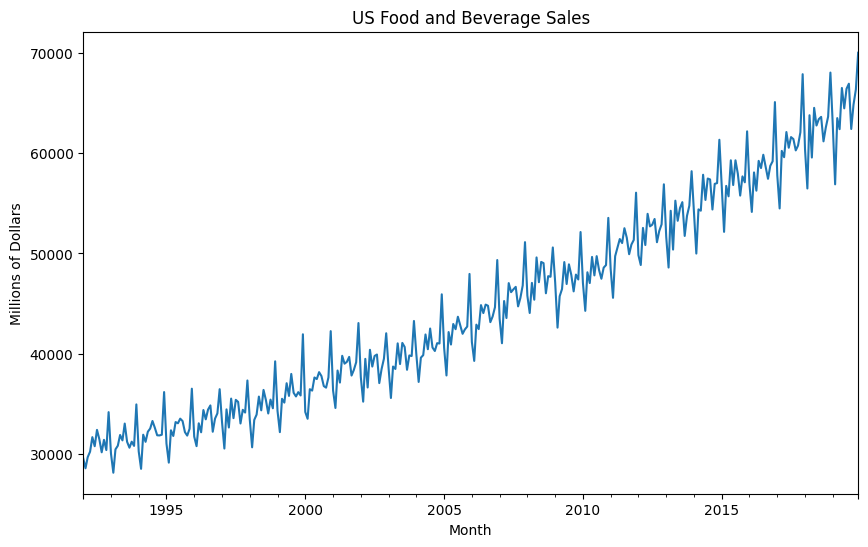

In [2]:
plot_params = {'figsize': (10, 6)}


ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars")

Now let's make a moving average plot to estimate the trend for this series!

In [3]:
trend = food_sales.rolling(
    window=12,
    center=True,
    min_periods=6,
).mean()

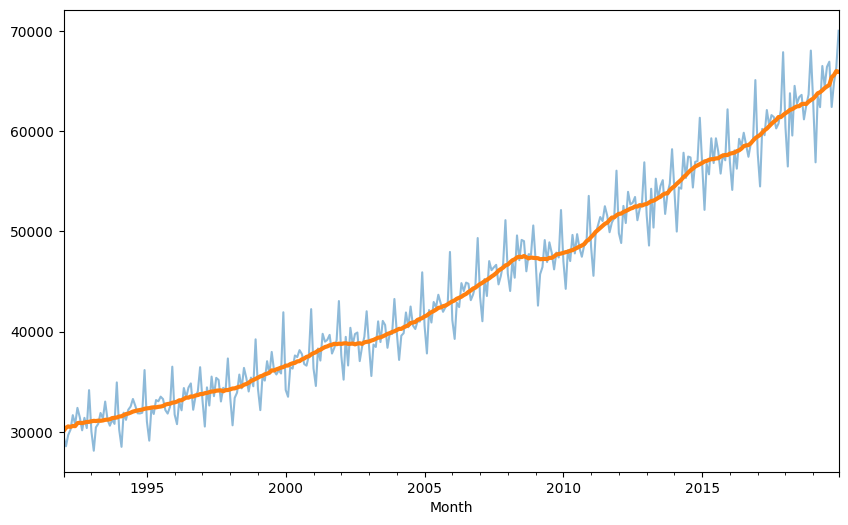

In [4]:
ax = food_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# 2) Identify trend

What order polynomial trend might be appropriate for the *Food and Beverage Sales* series? Can you think of a non-polynomial curve that might work even better?

-->>The upwards bend in the trend suggests an order 2 (quadratic) polynomial might be appropriate.

Now let's see a moving average plot of average_sales estimating the trend.

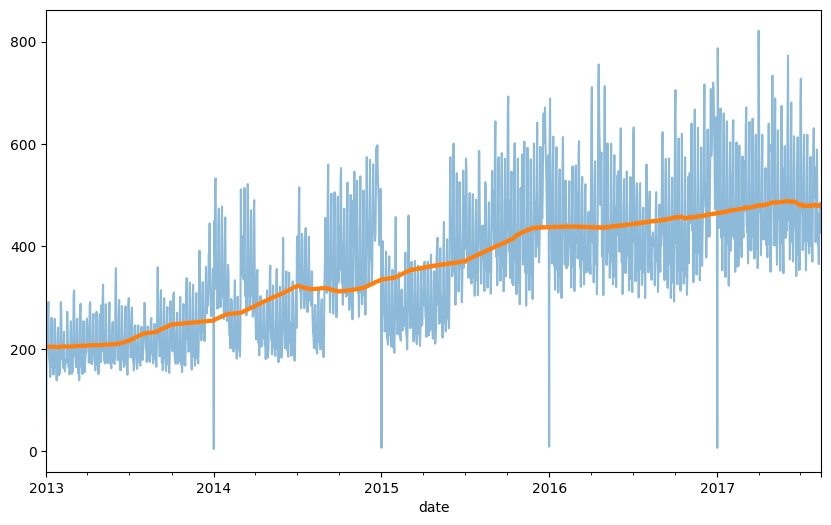

In [5]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# 3) Create a Trend Feature

We will use `DeterministicProcess` to create a feature set for a cubic trend model. Also we will create features for a 90-day forecast.

In [6]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

# Instantiate `DeterministicProcess` with arguments appropriate for a cubic trend model
dp = DeterministicProcess(
   index=y.index, order=3          
)


#Create the feature set for the dates given in y.index
X = dp.in_sample()

#Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)


Results:

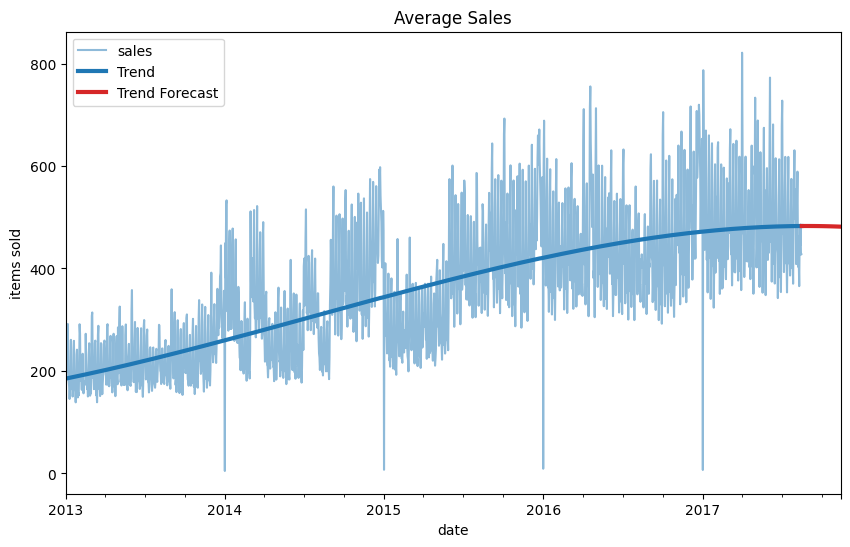

In [7]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

One way to fit more complicated trends is to increase the order of the polynomial we use. To get a better fit to the somewhat complicated trend in Store Sales, we could try using an order 11 polynomial.

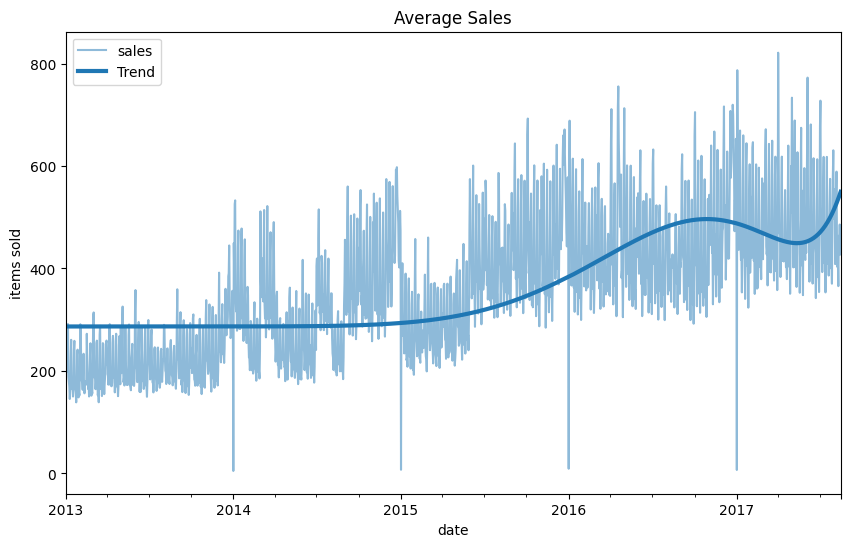

In [19]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend()

# 4) Understand risks of forecasting with high-order polynomials

High-order polynomials are generally not well-suited to forecasting, because an order 11 polynomial will include terms like t ** 11. Terms like these tend to diverge rapidly outside of the training period making forecasts very unreliable.

 let's see the same 90-day forecast using an order 11 polynomial. Does it confirm the intuition?

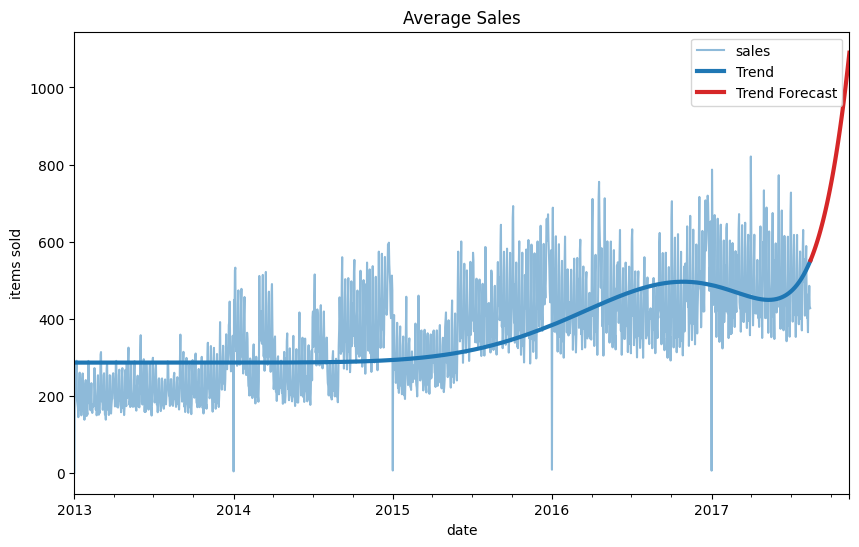

In [20]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

Not really!!
